In [1]:
import numpy as np
import os
import re
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time


In [2]:
def haversine_distance(loc1, loc_array):
    """
    Calculate the Haversine distance between a point and an array of points on the Earth
    given their latitude and longitude in decimal degrees.

    Parameters:
    - loc1: Tuple containing the latitude and longitude of the first point (in decimal degrees).
    - loc_array: Array of tuples, each containing the latitude and longitude of a point (in decimal degrees).

    Returns:
    - Array of distances between loc1 and each point in loc_array (in kilometers).
    """
    if np.isnan(loc1[0]) and np.isnan(loc1[1]):
        distances = np.zeros(len(loc_array))
    else:
        # Radius of the Earth in kilometers
        R = 6371.0

        # Convert decimal degrees to radians
        lat1_rad, lon1_rad = np.radians(loc1)
        lat2_rad, lon2_rad = np.radians(np.array(loc_array).T)

        # Haversine formula
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad

        a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        distances = R * c
    return distances

# FLX

In [3]:
from DA_operators import operator_clm_SMAP, operator_clm_FLX
from settings import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap
date_results_iter = [pd.date_range(datetime(2019,1,1),datetime(2019,12,31))]

In [5]:
operator = {}
data_measured = {}
data_latlon = {}
data_var = {}
data_dates = {}
operator['FLX'] = operator_clm_FLX(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_FLX'],ignore_rivers=False)
data_measured['FLX'],data_var['FLX'],data_latlon['FLX'],data_dates['FLX'] = operator['FLX'].get_measurements(date_results_iter,return_latlon=True,return_date=True)


No corrected LE values found for BE-Bra
No corrected LE values found for BE-Dor
No corrected LE values found for BE-Lcr
No corrected LE values found for BE-Maa
No corrected LE values found for CH-Aws
No corrected LE values found for CH-Dav
No corrected LE values found for CH-Fru
No corrected LE values found for CH-Lae
No corrected LE values found for CH-Oe2
No corrected LE values found for CZ-Lnz
No corrected LE values found for CZ-Stn
No corrected LE values found for DE-Akm
No corrected LE values found for DE-RuW
No corrected LE values found for DK-Gds
No corrected LE values found for DK-Sor
No corrected LE values found for ES-Agu
No corrected LE values found for FI-Ken
No corrected LE values found for FI-Qvd
No corrected LE values found for FI-Sii
No corrected LE values found for FR-FBn
No corrected LE values found for FR-Fon
No corrected LE values found for FR-LGt
No corrected LE values found for IT-Lav
No corrected LE values found for IT-Ren


2019-01-02 00:00:00 16
2019-02-02 00:00:00 474
2019-03-05 00:00:00 908
2019-04-05 00:00:00 1468
2019-05-06 00:00:00 2088
2019-06-06 00:00:00 2708
2019-07-07 00:00:00 3328
2019-08-07 00:00:00 3948
2019-09-07 00:00:00 4568
2019-10-08 00:00:00 5188
2019-11-08 00:00:00 5742
2019-12-09 00:00:00 6238


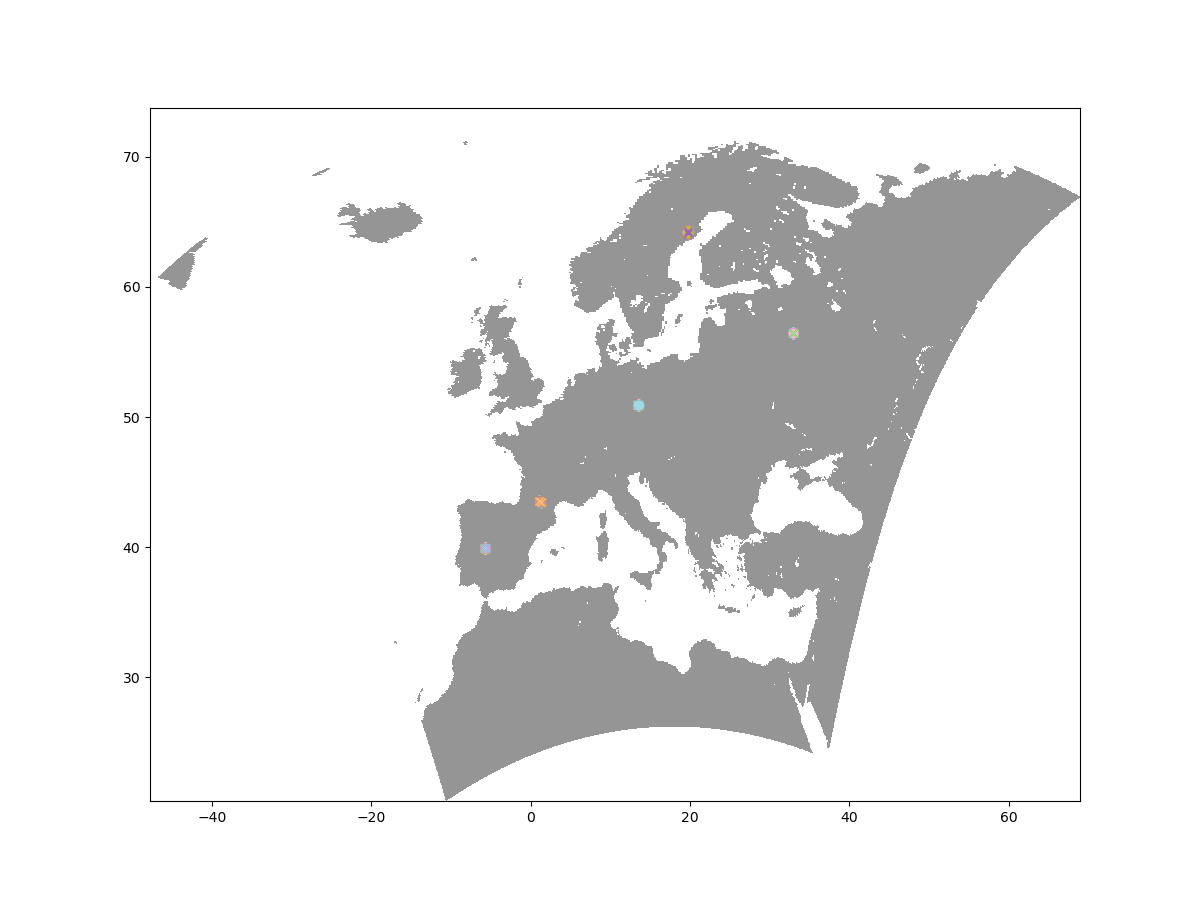

In [7]:
x_lower = np.linspace(0,12.5*2,1+(2*2))
x_upper = x_lower + 12.5

%matplotlib widget
results_all_dx = {}

for x_low_,x_upp_ in zip(x_lower[:1],x_upper[:1]):


    plt.figure(figsize=(12,9))
    plt.pcolormesh(operator['FLX'].grid_TSMP['lon_corner'],
                   operator['FLX'].grid_TSMP['lat_corner'],
                   operator['FLX'].grid_TSMP['lsm']==2,
                   cmap=plt.cm.Greys,vmax=2 )

    colors = plt.cm.tab20
    symbols = ['o','x','+','d','^','v','<','>']

    x_mean = .5*(x_low_+x_upp_)
    results_all_dx[x_mean] = {}

    results = results_all_dx[x_mean]
    results['monthly'] = {}
    results['yearly'] = {}

    results['monthly']['n_tot'] = 12*[0]
    results['monthly']['diff_sq'] = 12*[0]
    results['monthly']['diff_log10_sq'] = 12*[0]
    results['monthly']['pairs_x'] = [[] for i in range(12)] 
    results['monthly']['pairs_y'] = [[] for i in range(12)]
    results['monthly']['pairs_log10_x'] = [[] for i in range(12)] 
    results['monthly']['pairs_log10_y'] = [[] for i in range(12)]

    results['yearly']['n_tot'] = 0
    results['yearly']['diff_sq'] = 0
    results['yearly']['diff_log10_sq'] = 0
    # results['yearly']['pairs_x'] = []
    # results['yearly']['pairs_y'] = 0

    # delta_x = 12.5

    delta_t = timedelta(days=1)
    gamma = []
    c=0
    n_tot = 0
    diff_squared = 0
    dates_unique = np.unique(np.array(data_dates['FLX']))
    for i2,time_ in enumerate(dates_unique):
        mask_t = (np.array(data_dates['FLX']) == time_)
        array_latlon = data_latlon['FLX'][mask_t]
        array_flx = data_measured['FLX'][mask_t]
        i_month = time_.month - 1

        for i1,((lat_, lon_),flx_) in enumerate(zip(array_latlon,array_flx)):
            dx = haversine_distance((lat_,lon_),array_latlon)
            # dt = np.abs(np.array([time_ - date_item for date_item in data_dates['FLX']]))

            mask = (dx < x_upp_) & (dx >= x_low_)
            mask[i1] = False #don't compare values with themselves

            mask_log = mask.copy()
            mask_log[array_flx <= 0] = False

            if mask.sum() > 0:
                sym_ = (c//20)%8
                col_ = c%20
                plt.plot(lon_,lat_,symbols[sym_],color=colors(col_))
                plt.plot(array_latlon[mask][:,1],array_latlon[mask][:,0],symbols[sym_],color=colors(col_))

                dflx = flx_ - array_flx[mask]

                results['monthly']['n_tot'][i_month] += mask.sum()
                results['monthly']['diff_sq'][i_month] += np.sum(dflx**2)
                results['monthly']['pairs_x'][i_month].extend([flx_]*len(dflx))
                results['monthly']['pairs_y'][i_month].extend(list(array_flx[mask]))

                results['yearly']['n_tot'] += mask.sum()
                results['yearly']['diff_sq'] += np.sum(dflx**2)

                if flx_ > 0:
                    dflx_log10 = np.log10(flx_) - np.log10(array_flx[mask_log]) 
                    results['monthly']['diff_log10_sq'][i_month] += np.sum(dflx_log10**2)
                    results['yearly']['diff_log10_sq'] += np.sum(dflx_log10**2)
                    results['monthly']['pairs_log10_x'][i_month].extend([np.log10(flx_)]*len(dflx_log10))
                    results['monthly']['pairs_log10_y'][i_month].extend(list(np.log10(array_flx[mask_log])))                

                # results['yearly']['pairs_x'][i_month].extend([flx_]*len(dflx))
                # results['yearly']['pairs_y'][i_month].extend(list(array_flx[mask]))

                diff_squared += np.sum(dflx**2)
                n_tot += mask.sum()

                c+=1

        if i2 % 31 == 0:
            print(time_,results['yearly']['n_tot'])



0.8501857432930353


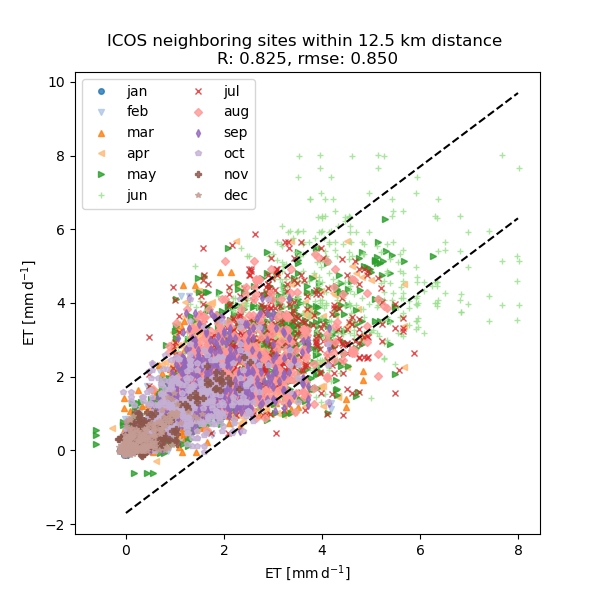

In [17]:
from scipy.stats import pearsonr
from itertools import chain


x_all = np.array(list(chain(*results['monthly']['pairs_x'])))
y_all = np.array(list(chain(*results['monthly']['pairs_y'])))
R = pearsonr(x_all,y_all)[0]
rmse = np.sqrt(np.mean((x_all-y_all)**2))

sigma = np.sqrt(results['yearly']['diff_sq'] / (1*results['yearly']['n_tot']))
print(sigma)

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
markers = ["o", "v", "^", "<", ">", "+", "x", "D", "d", "p", "P","*", "h", "H", "X" ,"1", "2", "3", "4", "s", ]

cmap = plt.cm.tab20
plt.figure(figsize=(6,6))
for i in range(12):
    plt.plot(results['monthly']['pairs_x'][i],results['monthly']['pairs_y'][i],markers[i],color=cmap(i),label=months[i],alpha=.8,markersize=4)

    sigma_i = np.sqrt(results['monthly']['diff_sq'][i] / (1*results['monthly']['n_tot'][i]))
    # plt.plot([0,8],[0+2*sigma_i,8+2*sigma_i],'--',color=cmap(i),linewidth=1)
    # plt.plot([0,8],[0-2*sigma_i,8-2*sigma_i],'--',color=cmap(i),linewidth=1)

plt.plot([0,8],[0+2*sigma,8+2*sigma],'k--')
plt.plot([0,8],[0-2*sigma,8-2*sigma],'k--')

plt.legend(ncol=2)
plt.title('ICOS neighboring sites within 12.5 km distance \nR: %3.3f, rmse: %3.3f' % (R,rmse) )
plt.xlabel('ET [mm$\,$d$^{-1}$]')
plt.ylabel('ET [mm$\,$d$^{-1}$]')

plt.savefig('figures/var_icos_pairs.png')
plt.savefig('figures/var_icos_pairs.pdf')


In [ ]:

x_all = np.array(list(chain(*results['monthly']['pairs_log10_x'])))
y_all = np.array(list(chain(*results['monthly']['pairs_log10_y'])))
R = pearsonr(x_all,y_all)[0]
rmse = np.sqrt(np.mean((x_all-y_all)**2))

plt.figure(figsize=(6,6))
for i in np.arange(12):
    plt.plot(results['monthly']['pairs_log10_x'][i],results['monthly']['pairs_log10_y'][i],'o',color=cmap(i),label='%i'%(i+1),alpha=.8,markersize=4)

    sigma_i = np.sqrt(results['monthly']['diff_log10_sq'][i] / (1*results['monthly']['n_tot'][i]))
    plt.plot([-5,1],[-5+2*sigma_i,1+2*sigma_i],'--',color=cmap(i),linewidth=1)
    plt.plot([-5,1],[-5-2*sigma_i,1-2*sigma_i],'--',color=cmap(i),linewidth=1)    
plt.legend(ncol=2)
plt.title('Points within 12.5 km distance \nR: %3.3f, rmse: %3.3f' % (R,rmse) )
plt.xlabel('log10(ET) [mm/d]')
plt.ylabel('log10(ET) [mm/d]')



In [5]:
# 13.5, 50.9
# DE_Gri
# DE-Hzd
# DE-Kli
# DE-Tha

# 'ES-LM1'
# 'ES-LM2'

# key1 = 'RU-Fy2'
# key2 = 'RU-Fyo'

# key1 = 'FR-Lam'
# key2 = 'FR-Aur'

# key1 = 'DE-Hzd' #xx
# key2 = 'DE-Tha' #enf

# key1 = 'DE-Gri' #both crop sites? Or one grass? 
# key2 = 'DE-Kli'

key1 = 'FR-Lam'
key2 = 'FR-Aur'
id_ = np.intersect1d(np.array(list(operator['FLX'].data_flx[key1]['LE_CORR'].keys())),np.array(list(operator['FLX'].data_flx[key2]['LE_CORR'].keys())), return_indices=True )

print(operator['FLX'].data_flx[key1]['lat'],',',operator['FLX'].data_flx[key1]['lon'])
print(operator['FLX'].data_flx[key2]['lat'],',',operator['FLX'].data_flx[key2]['lon'])

x_ = np.array(list(operator['FLX'].data_flx[key1]['LE_CORR'].values()))[id_[1]]
y_ = np.array(list(operator['FLX'].data_flx[key2]['LE_CORR'].values()))[id_[2]]
print(np.std(x_-y_))


key1 = 'ES-LM1'
key2 = 'ES-LM2'
id_ = np.intersect1d(np.array(list(operator['FLX'].data_flx[key1]['LE_CORR'].keys())),np.array(list(operator['FLX'].data_flx[key2]['LE_CORR'].keys())), return_indices=True )

print(operator['FLX'].data_flx[key1]['lat'],',',operator['FLX'].data_flx[key1]['lon'])
print(operator['FLX'].data_flx[key2]['lat'],',',operator['FLX'].data_flx[key2]['lon'])

x_ = np.array(list(operator['FLX'].data_flx[key1]['LE_CORR'].values()))[id_[1]]
y_ = np.array(list(operator['FLX'].data_flx[key2]['LE_CORR'].values()))[id_[2]]
print(np.std(x_-y_))


key1 = 'SE-Ros'
key2 = 'SE-Svb'
id_ = np.intersect1d(np.array(list(operator['FLX'].data_flx[key1]['LE_CORR'].keys())),np.array(list(operator['FLX'].data_flx[key2]['LE_CORR'].keys())), return_indices=True )

print(operator['FLX'].data_flx[key1]['lat'],',',operator['FLX'].data_flx[key1]['lon'])
print(operator['FLX'].data_flx[key2]['lat'],',',operator['FLX'].data_flx[key2]['lon'])

x_ = np.array(list(operator['FLX'].data_flx[key1]['LE_CORR'].values()))[id_[1]]
y_ = np.array(list(operator['FLX'].data_flx[key2]['LE_CORR'].values()))[id_[2]]
print(np.std(x_-y_))

43.496437 , 1.237878
43.54965 , 1.106103
0.3046969348238249
39.94269 , -5.778683
39.934592 , -5.775881
0.2151247392763056
64.1725 , 19.738
64.25611 , 19.7745
0.33341318713003654


In [10]:
results_all_dx.keys()

dict_keys([6.25])

Std:
[0.85018574]


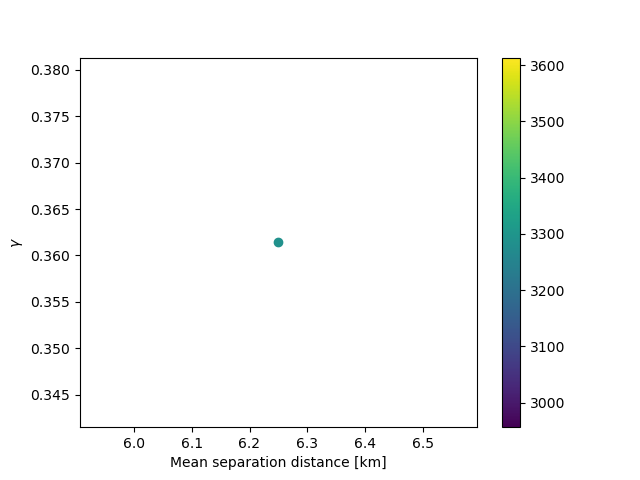

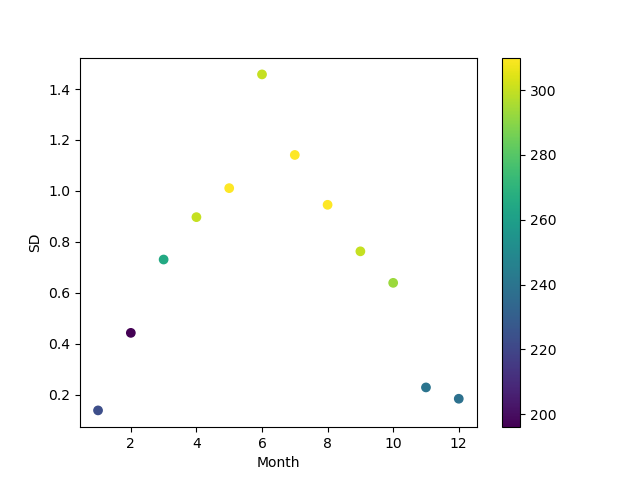

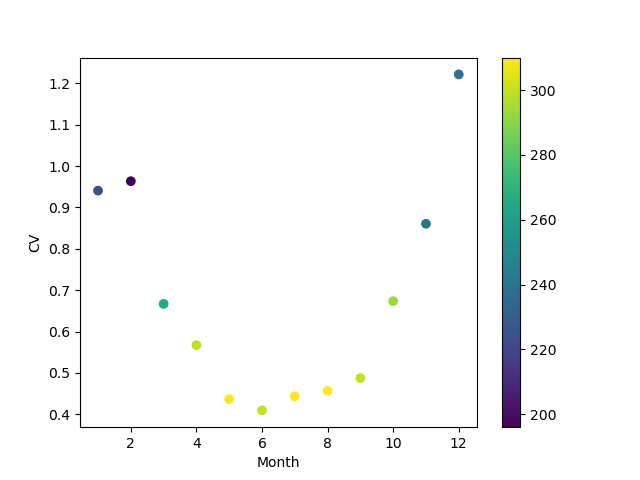

In [8]:
gamma = []
n_all = []
for key_ in results_all_dx.keys():
    results = results_all_dx[key_]
    if results['yearly']['n_tot'] > 0:
        gamma.append(results['yearly']['diff_sq'] / (2*results['yearly']['n_tot']))
    else:
        gamma.append(np.nan)
    n_all.append(results['yearly']['n_tot']/2)
    
plt.figure()
plt.scatter(list(results_all_dx.keys()),gamma,c=n_all)
plt.colorbar()
plt.xlabel('Mean separation distance [km]')
plt.ylabel(r'$\gamma$')

key_ = 6.25
results = results_all_dx[key_]

gamma_m = []
n_all = []
for m_ in np.arange(12):
    gamma_m.append(results['monthly']['diff_sq'][m_] / (2*results['monthly']['n_tot'][m_]))
    n_all.append(results['monthly']['n_tot'][m_]/2)
    # if results['monthly']['n_tot'][m_] > 0:
    #     gamma_m[m_].append(results['monthly']['diff_sq'][m_] / (2*results['monthly']['n_tot'][m_]))
    # else:
    #     gamma_m[m_].append(np.nan)
    # n_all.append(results['monthly']['n_tot'][m_]/2)

SD_monthly = np.sqrt(2*np.array(gamma_m))
mean_monthly = np.array([ np.mean(results['monthly']['pairs_x'][i]) for i in range(12)])
CV_monthly = SD_monthly / mean_monthly
    
plt.figure()
plt.scatter(np.arange(1,13),np.sqrt(2*np.array(gamma_m)),c=n_all)
plt.colorbar()
plt.xlabel('Month')
plt.ylabel(r'SD')    

plt.figure()
plt.scatter(np.arange(1,13),CV_monthly,c=n_all)
plt.colorbar()
plt.xlabel('Month')
plt.ylabel(r'CV') 

# i_month = 6
# gamma = []
# n_all = []
# for key_ in results_all_dx.keys():
#     results = results_all_dx[key_]
#     if results['monthly']['n_tot'][i_month] > 0:
#         gamma.append(results['monthly']['diff_sq'][i_month] / (2*results['monthly']['n_tot'][i_month]))
#     else:
#         gamma.append(np.nan)
#     n_all.append(results['monthly']['n_tot'][i_month]/2)
    
# plt.figure()
# plt.scatter(list(results_all_dx.keys()),gamma,c=n_all)
# plt.colorbar()
# plt.xlabel('Mean separation distance [km]')
# plt.ylabel(r'$\gamma$')
print('Std:')
print(np.sqrt(2*np.array(gamma)))

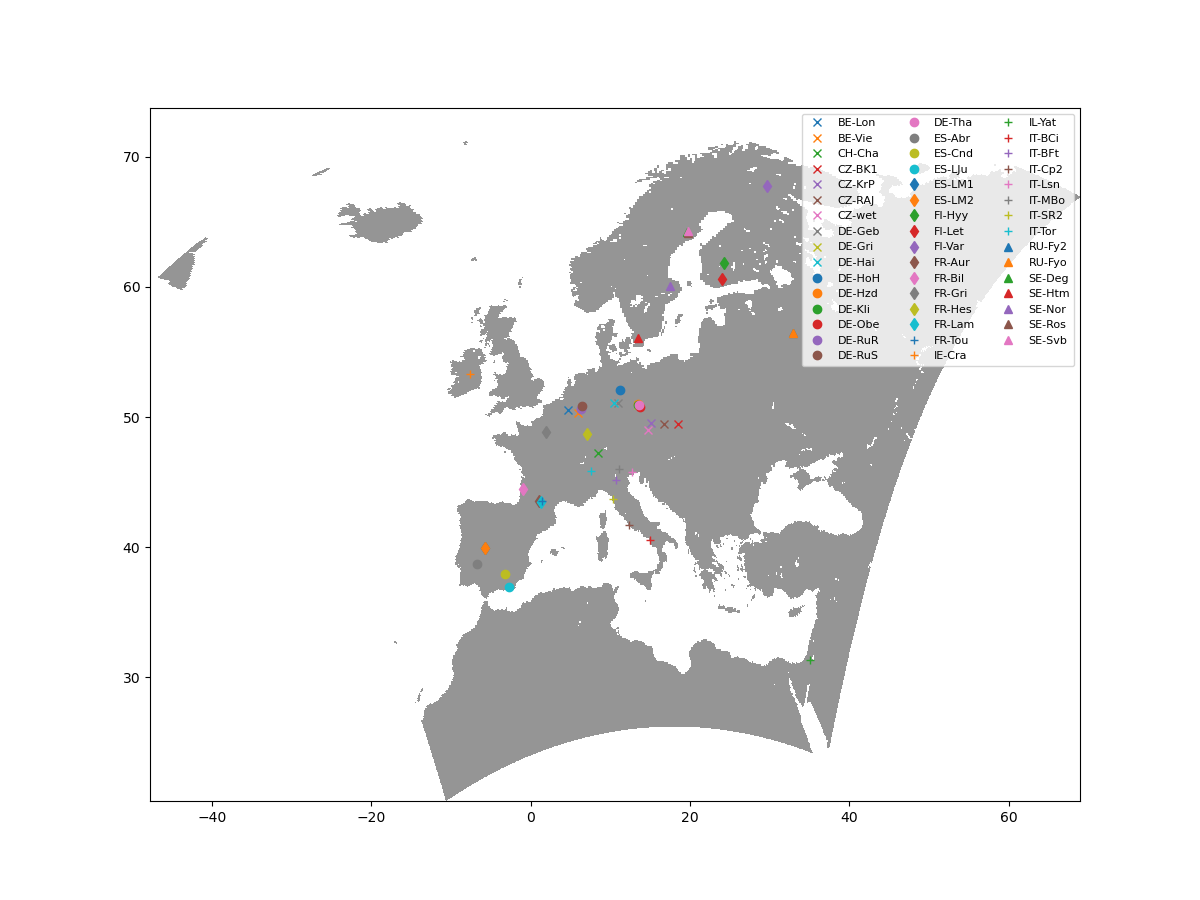

In [359]:
symbols = ['x','o','d','+','^','v']
plt.figure(figsize=(12,9))
plt.pcolormesh(operator['FLX'].grid_TSMP['lon_corner'],operator['FLX'].grid_TSMP['lat_corner'],
               operator['FLX'].grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )
for i1,flx_name in enumerate(operator['FLX'].data_flx.keys()):
    i_color = i1 % 10
    i_symbol = i1 // 10

    plt.plot(operator['FLX'].data_flx[flx_name]['lon'],operator['FLX'].data_flx[flx_name]['lat'],
             symbols[i_symbol],color=plt.cm.tab10(i_color),label=flx_name)
    plt.legend(fontsize=8,ncol=3)